In [1]:
%load_ext autoreload
%autoreload 2
from tf_activation import DeepGraph
from tf_activation.models import mnist_cff as mnist_model

import math
import random
import os

import networkx as nx
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.metrics import r2_score
%matplotlib inline
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data

In [146]:
mnist_map = {
    0: 3,
    1: 2,
    2: 1,
    3: 18,
    4: 4,
    5: 8,
    6: 11,
    7: 0,
    8: 61,
    9: 7
}

SAVE_PATH = '../logdir/models'
ADV_PATH = '../logdir/adversaries'
ELITE_PATH = '../logdir/elites'
DATA_PATH = '../logdir/data'
SAVE_FIG_LOC = '../logdir/figures'


mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allocator_type = 'BFC'
config.log_device_placement = True

persistence_module = tf.load_op_library('/home/tgebhart/python/tensorflow/bazel-bin/tensorflow/core/user_ops/nn_graph_persistence.so')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
im_1 = mnist.test.images[mnist_map[1]]
im_2 = mnist.test.images[mnist_map[2]]
im_rand = np.random.rand(im_2.shape[0])

steps = 200

columns = ['in_distance_1', 'in_distance_2', 'per_distance_1', 'per_distance_2', 'cross_entropy_1',
           'cross_entropy_2', 'y_conv_1', 'y_conv_2', 'accuracy_1', 'accuracy_2']
index = range(steps)
test_df = pd.DataFrame(index=index, columns=columns)

In [4]:
def create_path(start_im, end_im, steps=100):
    ret = []
    t = np.divide(end_im - start_im, steps)
    for i in range(1,steps+1):
        ret.append(start_im + i*t)
    return ret
    

In [5]:
path = create_path(im_1, im_rand) + create_path(im_rand, im_2)

In [6]:
# setup model
with tf.device('/cpu:0'):
    # Create the model
    x = tf.placeholder(tf.float32, [None, 784])

    # Define loss and optimizer
    y_ = tf.placeholder(tf.float32, [None, 10])

    # Build the graph for the deep net
    net, keep_prob = mnist_model.deepnn(x)

    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=net['y_conv']))
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.argmax(net['y_conv'], 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    saver = tf.train.Saver()

In [7]:
# run network
test_labels = np.stack((mnist.test.labels[mnist_map[1]],mnist.test.labels[mnist_map[2]]))
p = 95
with tf.Session(config=config) as sess:

    saver.restore(sess, os.path.join(SAVE_PATH, 'mnist_cff_2000.ckpt'))

    test_inputs_1 = np.stack((im_1, path[0]))
    test_inputs_2 = np.stack((im_2, path[0]))

    percentiles = persistence_module.layerwise_percentile([net['input'],
                                                        net['W_conv1'],
                                                        net['h_conv1'],
                                                        net['h_conv1'],
                                                        net['W_fc1'],
                                                        net['h_fc1'],
                                                        net['h_fc1_drop'],
                                                        net['W_fc2'],
                                                        net['y_conv']],
                                                        [0, 1, 2, 2, 1, 4, 4, 1, 4],
                                                        [p,p,p])

    ps1_1 = percentiles.eval(feed_dict={x: test_inputs_1[:1], keep_prob:1.0})
    ps1_2 = percentiles.eval(feed_dict={x: test_inputs_2[:1], keep_prob:1.0})
    
    for i in range(len(path)):
        
        test_inputs_1 = np.stack((im_1, path[i]))
        test_inputs_2 = np.stack((im_2, path[i]))
        in_distance_1 = np.linalg.norm(im_1 - path[i], ord=2)
        in_distance_2 = np.linalg.norm(im_2 - path[i], ord=2)

        ps2 = percentiles.eval(feed_dict={x: test_inputs_1[1:], keep_prob:1.0})

        result_1 = persistence_module.wasserstein_distance([net['input'],
                                                        net['W_conv1'],
                                                        net['h_conv1'],
                                                        net['h_conv1'],
                                                        net['W_fc1'],
                                                        net['h_fc1'],
                                                        net['h_fc1_drop'],
                                                        net['W_fc2'],
                                                        net['y_conv']],
                                                        [0, 1, 2, 2, 1, 4, 4, 1, 4],
                                                        np.stack((ps1_1, ps2))
                                                        )
        
        result_2 = persistence_module.wasserstein_distance([net['input'],
                                                        net['W_conv1'],
                                                        net['h_conv1'],
                                                        net['h_conv1'],
                                                        net['W_fc1'],
                                                        net['h_fc1'],
                                                        net['h_fc1_drop'],
                                                        net['W_fc2'],
                                                        net['y_conv']],
                                                        [0, 1, 2, 2, 1, 4, 4, 1, 4],
                                                        np.stack((ps1_2, ps2))
                                                        )


        per_distance_1 = result_1.eval(feed_dict={x: test_inputs_1, keep_prob:1.0})
        per_distance_2 = result_2.eval(feed_dict={x: test_inputs_2, keep_prob:1.0})
        print('Step: ', i)
        
        ce_1 = cross_entropy.eval(feed_dict={x:test_inputs_1[1:], y_:test_labels[:1], keep_prob:1.0})
        ce_2 = cross_entropy.eval(feed_dict={x:test_inputs_2[1:], y_:test_labels[1:], keep_prob:1.0})
        y_conv_1 = sess.run(net['y_conv'], feed_dict={x:test_inputs_1[1:], keep_prob:1.0})
        y_conv_2 = sess.run(net['y_conv'], feed_dict={x:test_inputs_2[1:], keep_prob:1.0})
        acc_1 = accuracy.eval(feed_dict={x:test_inputs_1[1:], y_:test_labels[:1], keep_prob:1})
        acc_2 = accuracy.eval(feed_dict={x:test_inputs_2[1:], y_:test_labels[1:], keep_prob:1})
        y_conv_1 = y_conv_1 / np.linalg.norm(y_conv_1)
        y_conv_2 = y_conv_2 / np.linalg.norm(y_conv_2)

        test_df.loc[i, 'in_distance_1'] = in_distance_1
        test_df.loc[i, 'per_distance_1'] = per_distance_1[0]
        test_df.loc[i, 'cross_entropy_1'] = ce_1
        test_df.loc[i, 'y_conv_1'] = y_conv_1[0,np.argmax(test_labels[0], axis=0)]
        test_df.loc[i, 'accuracy_1'] = acc_1
        
        test_df.loc[i, 'in_distance_2'] = in_distance_2
        test_df.loc[i, 'per_distance_2'] = per_distance_2[0]
        test_df.loc[i, 'cross_entropy_2'] = ce_2
        test_df.loc[i, 'y_conv_2'] = y_conv_2[0,np.argmax(test_labels[1], axis=0)]
        test_df.loc[i, 'accuracy_2'] = acc_2
        

INFO:tensorflow:Restoring parameters from ../logdir/models/mnist_cff_2000.ckpt
('Step: ', 0)
('Step: ', 1)
('Step: ', 2)
('Step: ', 3)
('Step: ', 4)
('Step: ', 5)
('Step: ', 6)
('Step: ', 7)
('Step: ', 8)
('Step: ', 9)
('Step: ', 10)
('Step: ', 11)
('Step: ', 12)
('Step: ', 13)
('Step: ', 14)
('Step: ', 15)
('Step: ', 16)
('Step: ', 17)
('Step: ', 18)
('Step: ', 19)
('Step: ', 20)
('Step: ', 21)
('Step: ', 22)
('Step: ', 23)
('Step: ', 24)
('Step: ', 25)
('Step: ', 26)
('Step: ', 27)
('Step: ', 28)
('Step: ', 29)
('Step: ', 30)
('Step: ', 31)
('Step: ', 32)
('Step: ', 33)
('Step: ', 34)
('Step: ', 35)
('Step: ', 36)
('Step: ', 37)
('Step: ', 38)
('Step: ', 39)
('Step: ', 40)
('Step: ', 41)
('Step: ', 42)
('Step: ', 43)
('Step: ', 44)
('Step: ', 45)
('Step: ', 46)
('Step: ', 47)
('Step: ', 48)
('Step: ', 49)
('Step: ', 50)
('Step: ', 51)
('Step: ', 52)
('Step: ', 53)
('Step: ', 54)
('Step: ', 55)
('Step: ', 56)
('Step: ', 57)
('Step: ', 58)
('Step: ', 59)
('Step: ', 60)
('Step: ', 61)
(

In [8]:
test_df.head()

,in_distance_1,in_distance_2,per_distance_1,per_distance_2,cross_entropy_1,cross_entropy_2,y_conv_1,y_conv_2,accuracy_1,accuracy_2
0,0.157832,9.7747,2.78343e+06,2.53409e+06,0.00277159,6.99275,0.823725,0.0905589,1,0
1,0.315664,9.72636,2.79952e+06,2.52131e+06,0.00360696,6.69169,0.822151,0.102016,1,0
2,0.473496,9.68035,2.82551e+06,2.51026e+06,0.00465571,6.40425,0.820348,0.11274,1,0
3,0.631329,9.63671,2.85104e+06,2.49811e+06,0.00597773,6.1335,0.818018,0.122108,1,0
4,0.789161,9.59547,2.87281e+06,2.48394e+06,0.00780225,5.84093,0.815194,0.133432,1,0


In [253]:
def regress(X, y, xlab, ylab, color_vals='b'):
    
    print(X.shape,y.shape)
    
    # Split the data into training/testing sets
    X_train = X[:-20]
    X_test = X[-20:]

    # Split the targets into training/testing sets
    y_train = y[:-20]
    y_test = y[-20:]

    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X_train, y_train)

    # The coefficients
    print('Coefficients: ', regr.coef_)
    # The mean squared error
    print("Mean squared error: %.2f"
          % np.mean((regr.predict(X_test) - y_test) ** 2))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % regr.score(X_test, y_test))
    print('R^2: %.2f' % r2_score(y_test, regr.predict(X_test)))
    
    fig, ax = plt.subplots()
    X_min = np.min(X)
    X_max = np.max(X)
    y_min = np.min(y)
    y_max = np.max(y)
    # Plot outputs
    
    ax.scatter(X, y,  color=color_vals, s=7)
#     ax.plot(X, regr.predict(X), color='blue', linewidth=3)


    ax.set_xlim(X_min, X_max)
    ax.set_ylim(y_min, y_max)
    
    plt.xlabel(xlab)
    plt.ylabel(ylab)
#     plt.title('{} vs {}'.format(xlab, ylab))
    plt.show()
    fig.savefig(os.path.join(SAVE_FIG_LOC, xlab + '_' + ylab + '.svg'), 
                format='svg', dpi=1200, bbox_inches='tight')


In [254]:
color_vals = ['#4286f4' if i < 100 else '#f4734b' for i in range(200)]

((200, 1), (200,))
('Coefficients: ', array([ 128201.08768997]))
Mean squared error: 1320482898742.84
Variance score: -29.97
R^2: -29.97


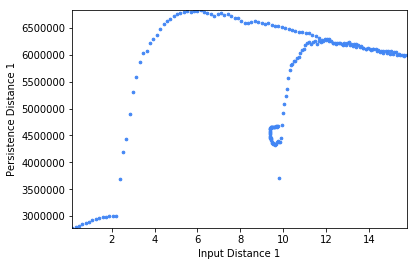

In [256]:
X = test_df['in_distance_1'].as_matrix()
X = X.reshape((X.shape[0], 1))
y = test_df['per_distance_1'].as_matrix()
regress(X, y, 'Input Distance 1', 'Persistence Distance 1', color_vals='#4286f4')

((26, 1), (26,))
('Coefficients: ', array([ 138905.06414753]))
Mean squared error: 3293575316599.65
Variance score: -0.76
R^2: -0.76


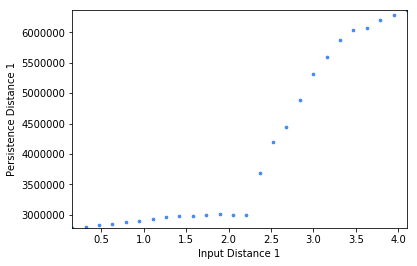

In [257]:
X = test_df['in_distance_1'].as_matrix()
X = X.reshape((X.shape[0], 1))
y = test_df['per_distance_1'].as_matrix()
regress(X[:26], y[:26], 'Input Distance 1', 'Persistence Distance 1', color_vals='#4286f4')

((200, 1), (200,))
('Coefficients: ', array([ 307.06317659]))
Mean squared error: 1421808121765.91
Variance score: -32.35
R^2: -32.35


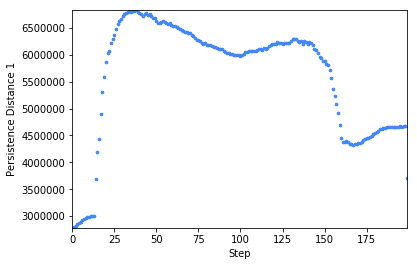

In [258]:
X = np.array(test_df.index)
X = X.reshape((X.shape[0], 1))
regress(X, y, 'Step', 'Persistence Distance 1', color_vals='#4286f4')

((200, 1), (200,))
('Coefficients: ', array([ 105634.26657857]))
Mean squared error: 2132559272332.88
Variance score: -49.02
R^2: -49.02


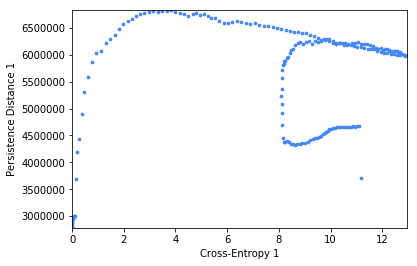

In [259]:
X = test_df['cross_entropy_1'].as_matrix()
X = X.reshape((X.shape[0], 1))
regress(X, y, 'Cross-Entropy 1', 'Persistence Distance 1', color_vals='#4286f4')

((26, 1), (26,))
('Coefficients: ', array([ 14179475.278343]))
Mean squared error: 64744769802433.14
Variance score: -33.51
R^2: -33.51


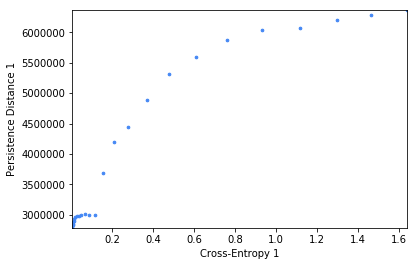

In [260]:
X = test_df['cross_entropy_1'].as_matrix()
X = X.reshape((X.shape[0], 1))
regress(X[:26], y[:26], 'Cross-Entropy 1', 'Persistence Distance 1', color_vals='#4286f4')

((200, 1), (200,))
('Coefficients: ', array([-2008824.97405779]))
Mean squared error: 790229616870.80
Variance score: -17.53
R^2: -17.53


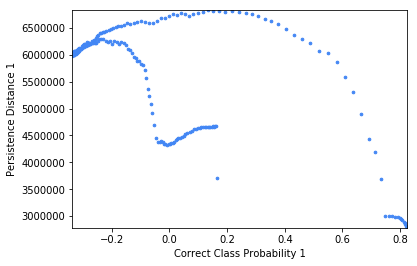

In [261]:
X = test_df['y_conv_1'].as_matrix()
X = X.reshape((X.shape[0], 1))
regress(X, y, 'Correct Class Probability 1', 'Persistence Distance 1', color_vals='#4286f4')

((26, 1), (26,))
('Coefficients: ', array([-9275960.49250445]))
Mean squared error: 198925525594.85
Variance score: 0.89
R^2: 0.89


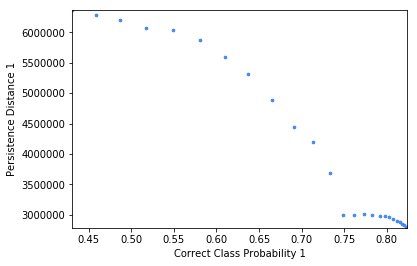

In [262]:
X = test_df['y_conv_1'].as_matrix()
X = X.reshape((X.shape[0], 1))
regress(X[:26], y[:26], 'Correct Class Probability 1', 'Persistence Distance 1', color_vals='#4286f4')

((200, 1), (200,))
('Coefficients: ', array([ 283188.7731781]))
Mean squared error: 271021662768.18
Variance score: -0.49
R^2: -0.49


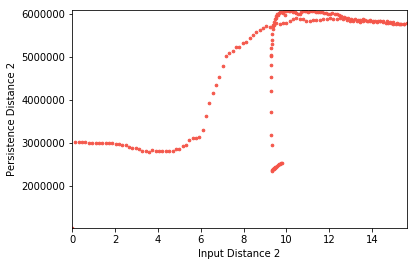

In [263]:
X = test_df['in_distance_2'].as_matrix()
X = X.reshape((X.shape[0], 1))
y = test_df['per_distance_2'].as_matrix()
regress(X, y, 'Input Distance 2', 'Persistence Distance 2', color_vals='#f4564a')

((200, 1), (200,))
('Coefficients: ', array([ 186914.7288095]))
Mean squared error: 3056863184506.67
Variance score: -15.76
R^2: -15.76


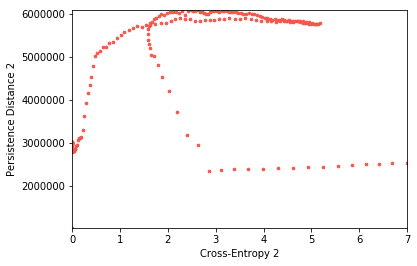

In [264]:
X = test_df['cross_entropy_2'].as_matrix()
X = X.reshape((X.shape[0], 1))
regress(X, y, 'Cross-Entropy 2', 'Persistence Distance 2', color_vals='#f4564a')

((200, 1), (200,))
('Coefficients: ', array([-1572129.89270736]))
Mean squared error: 3225596261976.72
Variance score: -16.69
R^2: -16.69


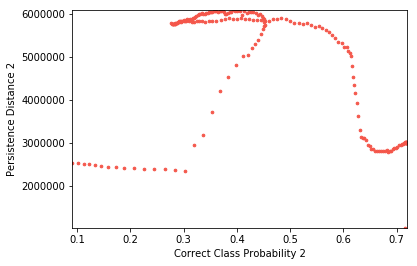

In [265]:
X = test_df['y_conv_2'].as_matrix()
X = X.reshape((X.shape[0], 1))
regress(X, y, 'Correct Class Probability 2', 'Persistence Distance 2', color_vals='#f4564a')

((200, 1), (200,))
('Coefficients: ', array([-1435.50519049]))
Mean squared error: 4468614940883.42
Variance score: -23.51
R^2: -23.51


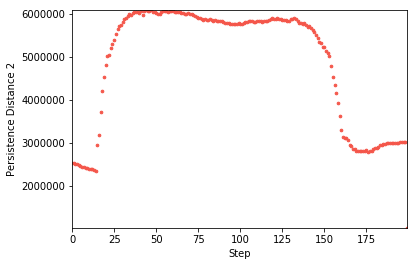

In [266]:
X = np.array(test_df.index)
X = X.reshape((X.shape[0], 1))
regress(X, y, 'Step', 'Persistence Distance 2', color_vals='#f4564a')

In [267]:
X = np.append(test_df['in_distance_1'].as_matrix(), test_df['in_distance_2'].as_matrix(), axis=0)
X = X.reshape((X.shape[0], 1))
y = np.append(test_df['per_distance_1'].as_matrix(), test_df['per_distance_2'].as_matrix(), axis=0)
color_vals = ['#4286f4' if i < X.shape[0]//2 else '#f4564a' for i in range(X.shape[0])]
regress(X, y, 'Inputplt.tight_layout()
', 'Persistence Distance', color_vals=color_vals)


SyntaxError: EOL while scanning string literal (<ipython-input-267-da433fe7fd71>, line 5)

In [ ]:
X = np.append(np.array(test_df.index), np.array(test_df.index), axis=0)
X = X.reshape((X.shape[0], 1))
y = np.append(test_df['per_distance_1'].as_matrix(), test_df['per_distance_2'].as_matrix(), axis=0)
color_vals = ['#4286f4' if i < X.shape[0]//2 else '#f4564a' for i in range(X.shape[0])]
regress(X, y, 'Step', 'Persistence Distance', color_vals=color_vals)